In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import os
import pandas as pd
import numpy as np 
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.42.1
Tensorflow version is: 1.14.0


In [4]:
def invTransform(scaler, data, colName, colNames):  
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [5]:
data_dir = './GHI_dataset/cleaned_sampled_data/'
file_path = os.path.join(data_dir, 'GHI_sampled_30_minutes.csv')
data_df = pd.read_csv(file_path, index_col=0)
print("Shape of the DataFrame:", data_df.shape)
print(data_df.head())
batch_size = min(64, int(data_df.shape[0]))

Shape of the DataFrame: (43897, 16)
                           GHI       GHIcs         k    GHI_d1  GHIcs_d1  \
datetime                                                                   
2016-01-08 07:30:00  15.550000   31.262880  0.497416  0.003233  0.026436   
2016-01-08 08:00:00  26.166939   58.447822  0.448858  0.009317  0.030799   
2016-01-08 08:30:00  26.830639  116.966722  0.233891 -0.000003  0.032983   
2016-01-08 09:00:00  67.965639  174.381655  0.380733  0.029884  0.030332   
2016-01-08 09:30:00  62.512189  224.879353  0.283073 -0.013863  0.025556   

                         k_d1    GHI_d2      GHIcs_d2          k_d2    GHI_d3  \
datetime                                                                        
2016-01-08 07:30:00 -0.000320  0.000017  7.593327e-06  9.787844e-07  0.000092   
2016-01-08 08:00:00 -0.000068 -0.000015  3.655401e-06 -5.539838e-08  0.000284   
2016-01-08 08:30:00 -0.000084  0.000017 -5.216457e-07  2.339614e-07 -0.000005   
2016-01-08 09:00:00  0.000

In [6]:
nPrevSteps = 5
polynomialAug = 5
basicFeatures = ['GHI', 'GHIcs', 'k']

In [7]:
nFeatures = len(basicFeatures)
X = data_df.loc[:, basicFeatures]
print("Array X", X.head())

Array X                            GHI       GHIcs         k
datetime                                            
2016-01-08 07:30:00  15.550000   31.262880  0.497416
2016-01-08 08:00:00  26.166939   58.447822  0.448858
2016-01-08 08:30:00  26.830639  116.966722  0.233891
2016-01-08 09:00:00  67.965639  174.381655  0.380733
2016-01-08 09:30:00  62.512189  224.879353  0.283073


In [8]:
poly = PolynomialFeatures(polynomialAug)
X_poly = poly.fit_transform(X)
colNames = poly.get_feature_names_out(X.columns)
#print("Augmented Column Names", colNames)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_poly)
scaled = scaler.transform(X_poly)
scaled = pd.DataFrame(scaled, columns = colNames, index = data_df.index)
scaled = scaled.drop("1", axis=1)
nFeatureColumns = scaled.shape[1]
print("Data Frame: ", scaled.head())
print("Data Frame Feature Columns: ", nFeatureColumns)

Data Frame:                            GHI     GHIcs         k     GHI^2  GHI GHIcs  \
datetime                                                                 
2016-01-08 07:30:00  0.013847  0.001474  0.019540  0.000249   0.000482   
2016-01-08 08:00:00  0.024729  0.033485  0.017603  0.000712   0.001701   
2016-01-08 08:30:00  0.025409  0.102391  0.009027  0.000749   0.003581   
2016-01-08 09:00:00  0.067571  0.169997  0.014885  0.004828   0.013762   
2016-01-08 09:30:00  0.061981  0.229457  0.010989  0.004084   0.016339   

                        GHI k   GHIcs^2   GHIcs k       k^2     GHI^3  ...  \
datetime                                                               ...   
2016-01-08 07:30:00  0.000314  0.000099  0.012927  0.000393  0.000004  ...   
2016-01-08 08:00:00  0.000477  0.003258  0.023170  0.000320  0.000019  ...   
2016-01-08 08:30:00  0.000254  0.016551  0.024246  0.000087  0.000021  ...   
2016-01-08 09:00:00  0.001054  0.038213  0.061670  0.000230  0.000336  ...   


In [10]:
train_test_df = pd.DataFrame()
for i in range(0, nPrevSteps+1, 1):
    title = scaled.columns + 't(-' + str(i) + ')'
    temp = scaled.shift(periods = i)
    temp.columns = title
    train_test_df = pd.concat([train_test_df, temp], axis=1)

print("Data Frame: ", train_test_df.head())
train_test_df = train_test_df.dropna()

Data Frame:                       GHIt(-0)  GHIcst(-0)    kt(-0)  GHI^2t(-0)  \
datetime                                                          
2016-01-08 07:30:00  0.013847    0.001474  0.019540    0.000249   
2016-01-08 08:00:00  0.024729    0.033485  0.017603    0.000712   
2016-01-08 08:30:00  0.025409    0.102391  0.009027    0.000749   
2016-01-08 09:00:00  0.067571    0.169997  0.014885    0.004828   
2016-01-08 09:30:00  0.061981    0.229457  0.010989    0.004084   

                     GHI GHIcst(-0)  GHI kt(-0)  GHIcs^2t(-0)  GHIcs kt(-0)  \
datetime                                                                      
2016-01-08 07:30:00        0.000482    0.000314      0.000099      0.012927   
2016-01-08 08:00:00        0.001701    0.000477      0.003258      0.023170   
2016-01-08 08:30:00        0.003581    0.000254      0.016551      0.024246   
2016-01-08 09:00:00        0.013762    0.001054      0.038213      0.061670   
2016-01-08 09:30:00        0.016339    0.00

In [11]:
title_0 = scaled.columns + 't(-' + str(0) + ')'
X = train_test_df.drop(title_0, axis = 1).values
y = train_test_df['GHIt(-0)'].values
print("Data Frame: ", X.shape)

Data Frame:  (43892, 275)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)
X_train_r = X_train.reshape((X_train.shape[0], nPrevSteps, nFeatureColumns))
X_validation_r = X_validation.reshape((X_validation.shape[0], nPrevSteps, nFeatureColumns))
X_test_r = X_test.reshape((X_test.shape[0], nPrevSteps, nFeatureColumns))

print("Shapes (X_train_R, X_validation_r, X_test_R)", X_train_r.shape, X_validation_r.shape, X_test_r.shape)

Shapes (X_train_R, X_validation_r, X_test_R) (35113, 5, 55) (4389, 5, 55) (4390, 5, 55)


In [13]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_r.shape[1], X_train_r.shape[2]))) 
model.add(LSTM(64, return_sequences=False, input_shape=(X_train_r.shape[1], X_train_r.shape[2])))
model.add(Dense(1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 0, patience=10, restore_best_weights=True)
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train_r, y_train, epochs=5, validation_split=0.2, batch_size=32, callbacks=[es], verbose=1, shuffle = False)

Train on 28090 samples, validate on 7023 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
28090/28090 [==============================] - 18s 640us/sample - loss: 0.0087 - val_loss: 0.0058
Epoch 2/5
28090/28090 [==============================] - 15s 548us/sample - loss: 0.0064 - val_loss: 0.0059
Epoch 3/5
28090/28090 [==============================] - 16s 566us/sample - loss: 0.0061 - val_loss: 0.0060
Epoch 4/5
28090/28090 [==============================] - 16s 561us/sample - loss: 0.0059 - val_loss: 0.0064
Epoch 5/5
28090/28090 [==============================] - 16s 552us/sample - loss: 0.0058 - val_loss: 0.0068


In [15]:
y_pred = model.predict(X_test_r)

print("Shape of Y_Pred: ", y_pred.shape)
print("Shape of Y_Test: ", y_test.shape)

y_pred_inv = invTransform(scaler, y_pred, 'GHI', colNames)
y_test_inv = invTransform(scaler, y_test, 'GHI', colNames)

print("Shape of Y_Pred_inv: ", y_pred.shape)
print("Shape of Y_test_inv: ", y_test.shape)

Shape of Y_Pred:  (4390, 1)
Shape of Y_Test:  (4390,)
Shape of Y_Pred_inv:  (4390, 1)
Shape of Y_test_inv:  (4390,)


In [16]:
mse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
nrmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)) / np.mean(y_test_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
nmae = mean_absolute_error(y_test_inv, y_pred_inv) / np.mean(y_test_inv) 
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {mse}, nRMSE: {nrmse}, MAE: {mae}, nMAE: {nmae}, R2: {r2}')

RMSE: 87.28018770789103, nRMSE: 0.2415049952141633, MAE: 64.56557538868061, nMAE: 0.17865347663354364, R2: 0.8845013084803137


In [17]:
sample_size = 100
subset_size = 100
colNames = colNames[1:]
random_indices = np.random.choice(X_train_r.shape[0], size=sample_size, replace=False)
X_train_sample = X_train_r[random_indices]

indices = np.random.choice(X_test_r.shape[0], subset_size, replace=False)
X_test_r_subset = X_test_r[indices]

In [18]:
explainer = shap.DeepExplainer(model, X_train_sample)
shap_values_subset = explainer.shap_values(X_test_r_subset)

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_subset[0][0][0], colNames)

In [20]:
print(np.asarray(shap_values_subset).shape)
print(np.asarray(X_test_r_subset).shape)

(1, 100, 5, 55)
(100, 5, 55)


In [21]:
shap_values_to_plot = np.squeeze(shap_values_subset)
feature_names_expanded = [f"{name}_t{t+1}" for t in range(X_test_r_subset.shape[1]) for name in colNames]
n_samples = X_test_r_subset.shape[0]
shap_values_flattened = shap_values_to_plot.reshape(n_samples, -1)
X_test_r_flattened = X_test_r_subset.reshape(n_samples, -1)

print("Shape of shap_values_flattened:", shap_values_flattened.shape)
print("Shape of X_test_r_flattened:", X_test_r_flattened.shape)

Shape of shap_values_flattened: (100, 275)
Shape of X_test_r_flattened: (100, 275)


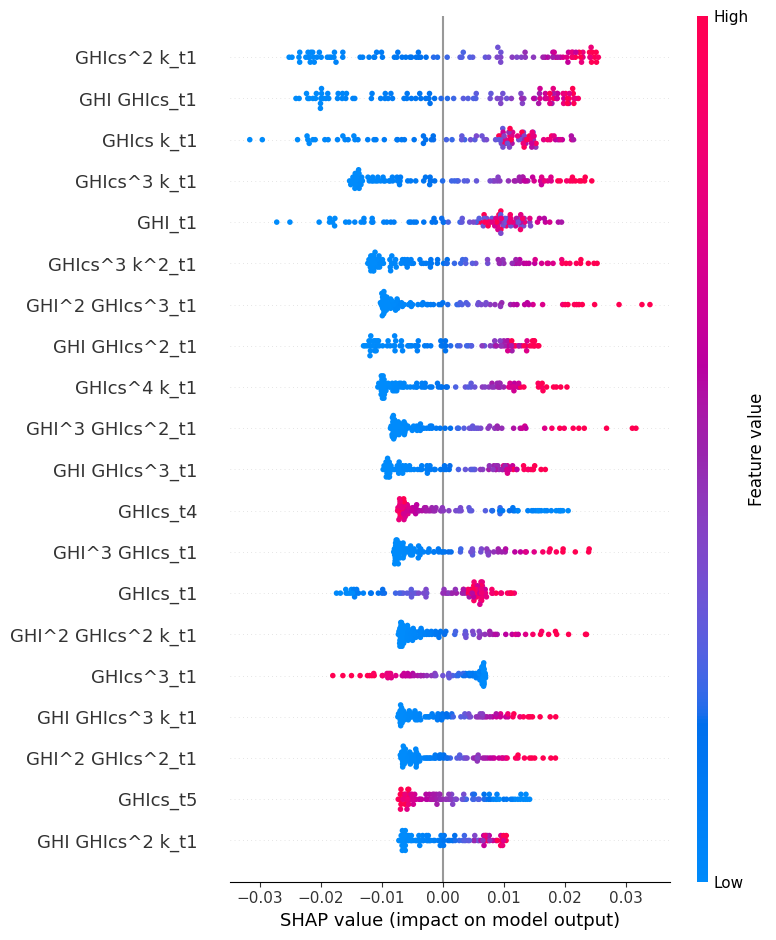

In [22]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, feature_names_expanded)

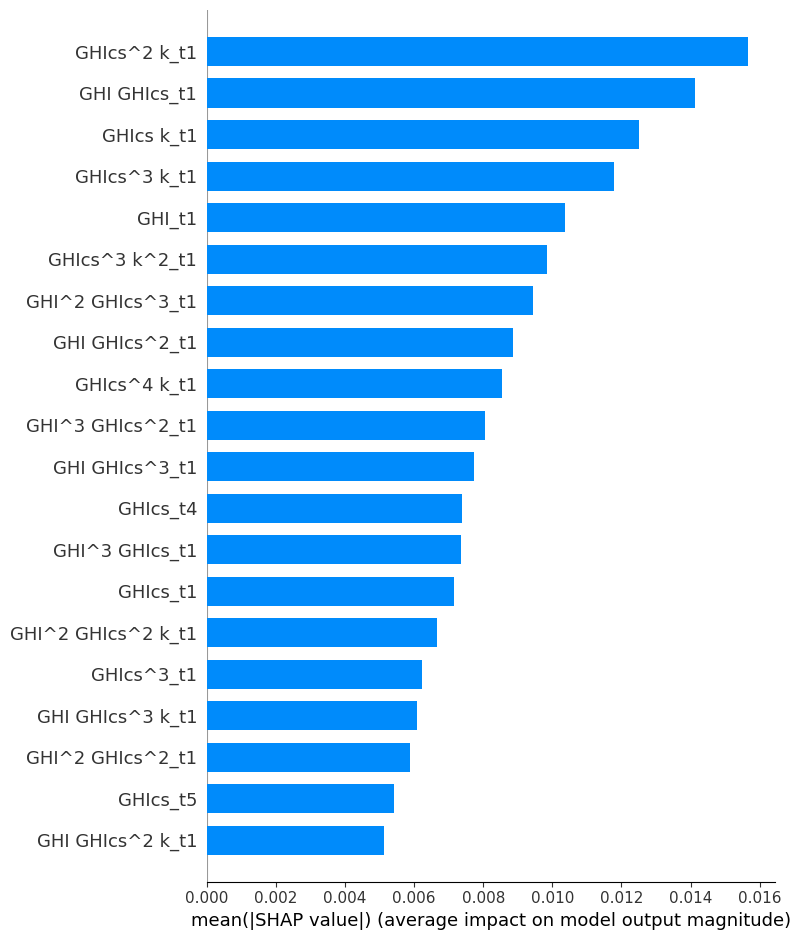

In [23]:
shap.summary_plot(shap_values_flattened, X_test_r_flattened, plot_type="bar", feature_names = feature_names_expanded)